# 🏨 Predicción de Precios de Airbnb en Madrid: Un Enfoque de Precios Hedónicos y Machine Learning

**Autor:** Luis Mauricio Aguirre Stornaiuolo
**Fecha:** Diciembre 2025

## 1. Introducción y Objetivos
El mercado de alquiler turístico en ciudades globales como Madrid presenta una alta variabilidad de precios. ¿Qué determina realmente el valor de una noche de alojamiento? ¿Es la ubicación, el lujo de los servicios o simplemente el número de camas?

Este proyecto tiene como objetivo desarrollar un **modelo de valoración hedónica** para estimar el precio de mercado de los inmuebles listados en Airbnb Madrid. Utilizando técnicas de **Data Science y Econometría**, buscamos:

1.  **Identificar los "Drivers" del Valor:** Entender qué características (estructurales y de ubicación) tienen mayor peso en la formación del precio.
2.  **Validar Teorías Económicas:** Comprobar si se cumple la hipótesis de *Alonso-Muth-Mills* (el precio disminuye al alejarse del centro).
3.  **Maximizar la Precisión Predictiva:** Comparar modelos lineales clásicos (OLS) frente a algoritmos de ensamblaje (Random Forest y XGBoost) para capturar no-linealidades del mercado.

---

In [393]:
#importamos drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [394]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [395]:
ruta = "/content/drive/MyDrive/PROYECTOS PERSONALES/listings.csv"
data = pd.read_csv(ruta)
data.head(5)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,21853,https://www.airbnb.com/rooms/21853,20250914152907,2025-09-15,previous scrape,Bright and airy room,We have a quiet and sunny room with a good vie...,We live in a leafy neighbourhood with plenty o...,https://a0.muscache.com/pictures/68483181/87bc...,83531,...,4.82,4.21,4.67,NaN,f,2,0,2,0,0.25
1,30320,https://www.airbnb.com/rooms/30320,20250914152907,2025-09-15,city scrape,Apartamentos Dana Sol,NaN,NaN,https://a0.muscache.com/pictures/336868/f67409...,130907,...,4.78,4.90,4.69,NaN,t,17,17,0,0,0.93
2,30959,https://www.airbnb.com/rooms/30959,20250914152907,2025-09-15,previous scrape,Beautiful loft in Madrid Center,Beautiful Loft 60m2 size just in the historica...,NaN,https://a0.muscache.com/pictures/78173471/835e...,132883,...,4.63,4.88,4.25,NaN,f,1,1,0,0,0.06
3,40916,https://www.airbnb.com/rooms/40916,20250914152907,2025-09-15,city scrape,Apartasol Apartamentos Dana,NaN,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,130907,...,4.81,4.88,4.59,NaN,t,17,17,0,0,0.29
4,62423,https://www.airbnb.com/rooms/62423,20250914152907,2025-09-15,city scrape,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,INCREDIBLE HOME OF AN ARTIST SURROUNDED BY PAI...,DISTRICT WITH VERY GOOD VIBES IN THE MIDDLE OF...,https://a0.muscache.com/pictures/miso/Hosting-...,303845,...,4.86,4.97,4.60,NaN,f,3,1,2,0,2.78


In [396]:
cols_to_use = [
    'price',                    # Target
    'accommodates',             # Capacidad (Proxy de tamaño)
    'bedrooms',                 # Estructural
    'beds',                     # Estructural
    'room_type',                # Estructural (Privada vs Entera)
    'bathrooms_text',           # Para limpiar y extraer número de baños
    'amenities',                # Para contar la cantidad de servicios
    'host_since',               # Para calcular 'years_experience'
    'latitude',                 # Para calcular Distancia del Centro
    'longitude',                # Para calcular Distancia del Centro
    'number_of_reviews_l30d'    # Para variable de actividad reciente (30 días)
]

In [397]:
#Configuramos data para que solo utilice las columnas de cols_to_use
data = data[cols_to_use]
data.head(5)

,price,accommodates,bedrooms,beds,room_type,bathrooms_text,amenities,host_since,latitude,longitude,number_of_reviews_l30d
0,NaN,1,NaN,NaN,Private room,1 bath,"[""First aid kit"", ""Hair dryer"", ""Bed linens"", ...",2010-02-21,40.40381,-3.74130,0
1,$157.00,2,1.0,2.0,Entire home/apt,1 bath,"[""TV with standard cable"", ""Elevator"", ""Air co...",2010-05-24,40.41476,-3.70418,1
2,NaN,2,1.0,NaN,Entire home/apt,1 bath,"[""TV with standard cable"", ""Elevator"", ""Pets a...",2010-05-26,40.41259,-3.70105,0
3,$143.00,2,1.0,3.0,Entire home/apt,1 bath,"[""Elevator"", ""Wifi"", ""Air conditioning"", ""TV"",...",2010-05-24,40.42247,-3.70577,1
4,$65.00,4,1.0,2.0,Private room,1.5 shared baths,"[""Cleaning products"", ""First aid kit"", ""Hair d...",2010-11-29,40.41884,-3.69655,4


##Limpieza de datos

In [398]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   18953 non-null  object 
 1   accommodates            25000 non-null  int64  
 2   bedrooms                22488 non-null  float64
 3   beds                    18965 non-null  float64
 4   room_type               25000 non-null  object 
 5   bathrooms_text          24972 non-null  object 
 6   amenities               25000 non-null  object 
 7   host_since              24903 non-null  object 
 8   latitude                25000 non-null  float64
 9   longitude               25000 non-null  float64
 10  number_of_reviews_l30d  25000 non-null  int64  
dtypes: float64(4), int64(2), object(5)
memory usage: 2.1+ MB


In [399]:
#Reemplazamos el simbolo $ y , en la columna Price
data["price"] = data["price"].str.replace("$", "").str.replace(",", "").astype(float)

In [400]:
#Generamos una nueva columna de bathrooms
data["bathrooms"] = data["bathrooms_text"].str.split(" ").str[0] #Extraemos la primera palabra de la columna inicial

In [401]:
data["bathrooms"] = data["bathrooms"].replace({"Half-bath": "0.5", "Private": "0.5", "Shared": "0.5"})

In [402]:
#Cambiamos el tipo de dato de bathrooms a float
data["bathrooms"] = data["bathrooms"].astype(float)

In [403]:
#Convertimos a fecha la variable host_since
data["host_since"] = pd.to_datetime(data["host_since"])

## 2. Ingeniería de Características y Tratamiento de Datos

Para preparar los datos para el modelado, se realizaron tres intervenciones clave basadas en la estadística y la teoría urbana:

* **Transformación Logarítmica (`log_price`):** La variable precio presentaba una distribución asimétrica (cola derecha larga). Se aplicó `np.log1p` para normalizar la distribución, estabilizar la varianza (homocedasticidad) y permitir interpretar los coeficientes como elasticidades (porcentajes).
* **Cálculo de Distancia (Haversine):** Utilizando las coordenadas de latitud y longitud, calculamos la distancia exacta de cada inmueble a la **Puerta del Sol** (Km 0). Esto nos permitirá medir el "castigo" que impone el mercado por la lejanía.
* **Codificación de Variables Categoricas:** La variable `room_type` es crítica. Se aplicó *One-Hot Encoding* para diferenciar numéricamente entre alquilar una casa entera, una habitación privada o compartida.

###Feature Engineering

In [404]:
#Creamos la variable años de experiencia
data["años_exp"] = 2025 - data["host_since"].dt.year

In [405]:
#Creamos la variable cant_servicios
data["amenities_count"] = data["amenities"].str.count(",") + 1

In [406]:
#Creamos una variable de distancia al centro de Madrid
#Utilizaremos las coordenadas de La Plaza de la Puerta del Sol como referencia
sol_lat = 40.416775
sol_lon = -3.703790

## 📍 2.1 Ingeniería de Atributos Espaciales: De Coordenadas a "Distancia Real"

Las coordenadas geográficas puras (`latitude`, `longitude`) son difíciles de interpretar para un modelo lineal estándar. Saber que un piso está en la latitud 40.41 no nos dice si es una ubicación "premium" o periférica sin un punto de referencia.

Para solucionar esto, aplicamos **Ingeniería de Características** transformando las coordenadas en una métrica de negocio tangible: **La distancia al centro turístico y económico.**

### 📐 La Fórmula del Haversine
Dado que la Tierra no es plana, no podemos usar la distancia euclidiana simple (Pitágoras). Utilizamos la **Fórmula del Haversine**, que calcula la distancia del círculo máximo entre dos puntos en una esfera:

$$
d = 2r \arcsin\left(\sqrt{\sin^2\left(\frac{\Delta\phi}{2}\right) + \cos(\phi_1)\cos(\phi_2)\sin^2\left(\frac{\Delta\lambda}{2}\right)}\right)
$$

Donde:
* $\phi$: Latitud
* $\lambda$: Longitud
* $r$: Radio de la Tierra (aprox. 6,371 km)

### 🏙️ El Punto de Referencia: Km 0 (Puerta del Sol)
Hemos definido el "centro" de Madrid basándonos en el Kilómetro Cero de las carreteras radiales de España, ubicado en la **Puerta del Sol**.

> **Hipótesis Económica (Modelo Monocéntrico):**
> Siguiendo el modelo urbano de *Alonso-Muth-Mills*, esperamos una **correlación negativa** entre esta nueva variable y el precio. A medida que la distancia al CBD (Central Business District) aumenta, el precio del suelo y de los alquileres debería disminuir debido a los costes de conmutación y menor accesibilidad.

In [407]:
#Función que calcula la distancia entre 2 puntos en base a coordenadas
def distancia_dos_puntos(lat1,lon1,lat2,lon2):
  R = 6371
  phi1, phi2 = np.radians(lat1), np.radians(lat2)
  dphi = np.radians(lat2 - lat1)
  dlambda = np.radians(lon2 - lon1)

  #Aplicamos la formula
  a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
  return R * c

In [408]:
data["distancia_del_centro"] = distancia_dos_puntos(data["latitude"],data["longitude"],sol_lat,sol_lon)

###Detección de Outliers e imputación de valores nulos

In [409]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   price                   18953 non-null  float64       
 1   accommodates            25000 non-null  int64         
 2   bedrooms                22488 non-null  float64       
 3   beds                    18965 non-null  float64       
 4   room_type               25000 non-null  object        
 5   bathrooms_text          24972 non-null  object        
 6   amenities               25000 non-null  object        
 7   host_since              24903 non-null  datetime64[ns]
 8   latitude                25000 non-null  float64       
 9   longitude               25000 non-null  float64       
 10  number_of_reviews_l30d  25000 non-null  int64         
 11  bathrooms               24972 non-null  float64       
 12  años_exp                24903 non-null  float6

In [410]:
data.isna().sum().sort_values(ascending=False)

,0
price,6047
beds,6035
bedrooms,2512
años_exp,97
host_since,97
bathrooms_text,28
bathrooms,28
amenities,0
room_type,0
accommodates,0


In [411]:
data_clean = data.dropna(subset=['price'])

In [412]:
data_clean.shape

(18953, 15)

In [413]:
data_clean.isna().mean()*100

,0
price,0.000000
accommodates,0.000000
bedrooms,0.158286
beds,0.073867
room_type,0.000000
bathrooms_text,0.110800
amenities,0.000000
host_since,0.490687
latitude,0.000000
longitude,0.000000


In [414]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18953 entries, 1 to 24999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   price                   18953 non-null  float64       
 1   accommodates            18953 non-null  int64         
 2   bedrooms                18923 non-null  float64       
 3   beds                    18939 non-null  float64       
 4   room_type               18953 non-null  object        
 5   bathrooms_text          18932 non-null  object        
 6   amenities               18953 non-null  object        
 7   host_since              18860 non-null  datetime64[ns]
 8   latitude                18953 non-null  float64       
 9   longitude               18953 non-null  float64       
 10  number_of_reviews_l30d  18953 non-null  int64         
 11  bathrooms               18932 non-null  float64       
 12  años_exp                18860 non-null  float64    

In [415]:
corr = data_clean._get_numeric_data().corr()
corr["price"].sort_values(ascending=False)

,price
price,1.000000
accommodates,0.146132
bedrooms,0.110609
beds,0.104591
bathrooms,0.080498
años_exp,0.023244
latitude,0.011116
amenities_count,0.006470
longitude,-0.015392
number_of_reviews_l30d,-0.027658


In [416]:
cols_to_fill = ['bedrooms', 'beds', 'bathrooms', 'años_exp']
data_clean[cols_to_fill] = data_clean[cols_to_fill].fillna(data_clean[cols_to_fill].median())

/tmp/ipython-input-3696138028.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean[cols_to_fill] = data_clean[cols_to_fill].fillna(data_clean[cols_to_fill].median())


In [417]:
cols_to_use = ['price', 'accommodates', 'bedrooms', 'beds', 'room_type',
        'number_of_reviews_l30d',
               'bathrooms', 'años_exp', 'amenities_count','distancia_del_centro']
data_clean = data_clean[cols_to_use]

In [418]:
data_clean.head(5)

,price,accommodates,bedrooms,beds,room_type,number_of_reviews_l30d,bathrooms,años_exp,amenities_count,distancia_del_centro
1,157.0,2,1.0,2.0,Entire home/apt,1,1.0,15.0,6,0.226477
3,143.0,2,1.0,3.0,Entire home/apt,1,1.0,15.0,6,0.655063
4,65.0,4,1.0,2.0,Private room,4,1.5,15.0,32,0.654515
6,116.0,2,1.0,1.0,Entire home/apt,0,1.0,14.0,36,0.648082
7,79.0,2,1.0,2.0,Entire home/apt,0,1.0,14.0,32,0.648082


(0.0, 1000.0)

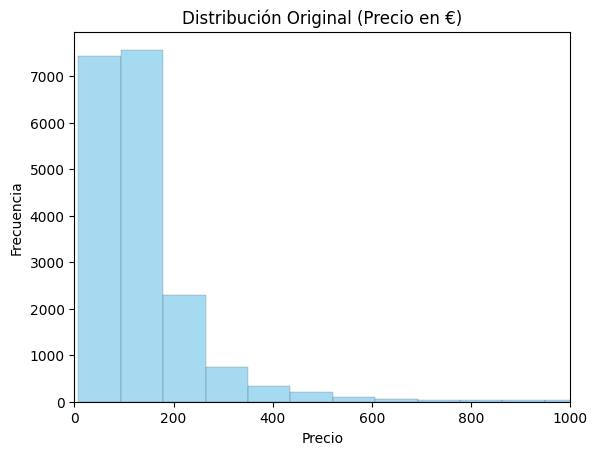

In [419]:
sns.histplot(data_clean['price'], bins=300, color='skyblue')
plt.title('Distribución Original (Precio en €)')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
# Limitamos el eje X para hacer Zoom en la mayoría (opcional, para ver mejor la barra gigante)
plt.xlim(0, 1000)

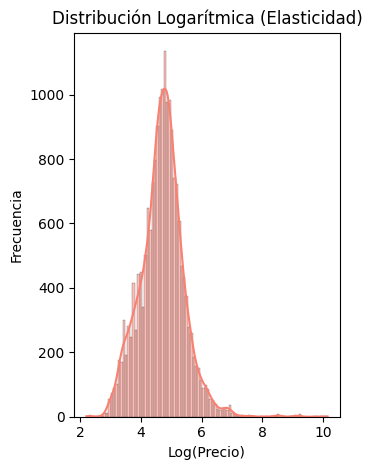

In [420]:
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(data_clean['price']), bins=100, color='salmon', kde=True)
plt.title('Distribución Logarítmica (Elasticidad)')
plt.xlabel('Log(Precio)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [421]:
data_clean["log_price"] = np.log1p(data_clean["price"])

In [422]:
data_clean.describe()

,price,accommodates,bedrooms,beds,number_of_reviews_l30d,bathrooms,años_exp,amenities_count,distancia_del_centro,log_price
count,18953.000000,18953.000000,18953.000000,18953.000000,18953.000000,18953.000000,18953.000000,18953.000000,18953.000000,18953.000000
mean,156.691447,3.307445,1.379518,1.987601,1.143829,1.310268,5.954677,27.522872,2.688172,4.692672
std,492.255350,1.956841,0.929192,1.523734,2.008555,0.704761,3.838553,13.231509,2.442522,0.723395
min,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.008903,2.197225
25%,70.000000,2.000000,1.000000,1.000000,0.000000,1.000000,3.000000,18.000000,0.776952,4.262680
50%,110.000000,3.000000,1.000000,2.000000,0.000000,1.000000,6.000000,28.000000,1.861753,4.709530
75%,164.000000,4.000000,2.000000,2.000000,2.000000,1.500000,9.000000,36.000000,4.003874,5.105945
max,25654.000000,16.000000,25.000000,40.000000,69.000000,19.000000,16.000000,95.000000,14.499671,10.152494


In [423]:
data_clean.shape

(18953, 11)

In [424]:
min_price = 10
max_price = data_clean["price"].quantile(0.99)

In [425]:
data_final = data_clean[
    (data_clean['price'] >= min_price) &
    (data_clean['price'] <= max_price)
].copy()

In [426]:
vars_cap = ['bedrooms', 'beds', 'bathrooms', 'amenities_count', 'number_of_reviews_l30d']
for var in vars_cap:
  limit = data_final[var].quantile(0.995)
  data_final[var] = data_final[var].clip(upper=limit)
  print(f"- {var}: Valores mayores a {limit} se han reducido a {limit}")

- bedrooms: Valores mayores a 5.0 se han reducido a 5.0
- beds: Valores mayores a 8.0 se han reducido a 8.0
- bathrooms: Valores mayores a 4.5 se han reducido a 4.5
- amenities_count: Valores mayores a 65.0 se han reducido a 65.0
- number_of_reviews_l30d: Valores mayores a 10.0 se han reducido a 10.0


In [427]:
data_final.shape

(18756, 11)

In [428]:
data_final.describe()

,price,accommodates,bedrooms,beds,number_of_reviews_l30d,bathrooms,años_exp,amenities_count,distancia_del_centro,log_price
count,18756.000000,18756.000000,18756.000000,18756.000000,18756.000000,18756.000000,18756.000000,18756.000000,18756.000000,18756.000000
mean,131.465025,3.284389,1.362924,1.949989,1.132064,1.295159,5.950842,27.560621,2.690118,4.666808
std,96.788487,1.907415,0.854195,1.298628,1.828561,0.623070,3.839062,13.101080,2.442048,0.669028
min,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.008903,2.397895
25%,70.000000,2.000000,1.000000,1.000000,0.000000,1.000000,3.000000,18.000000,0.777964,4.262680
50%,110.000000,3.000000,1.000000,2.000000,0.000000,1.000000,6.000000,28.000000,1.865928,4.709530
75%,161.000000,4.000000,2.000000,2.000000,2.000000,1.500000,9.000000,36.000000,4.006063,5.087596
max,790.000000,16.000000,5.000000,8.000000,10.000000,4.500000,16.000000,65.000000,14.499671,6.673298


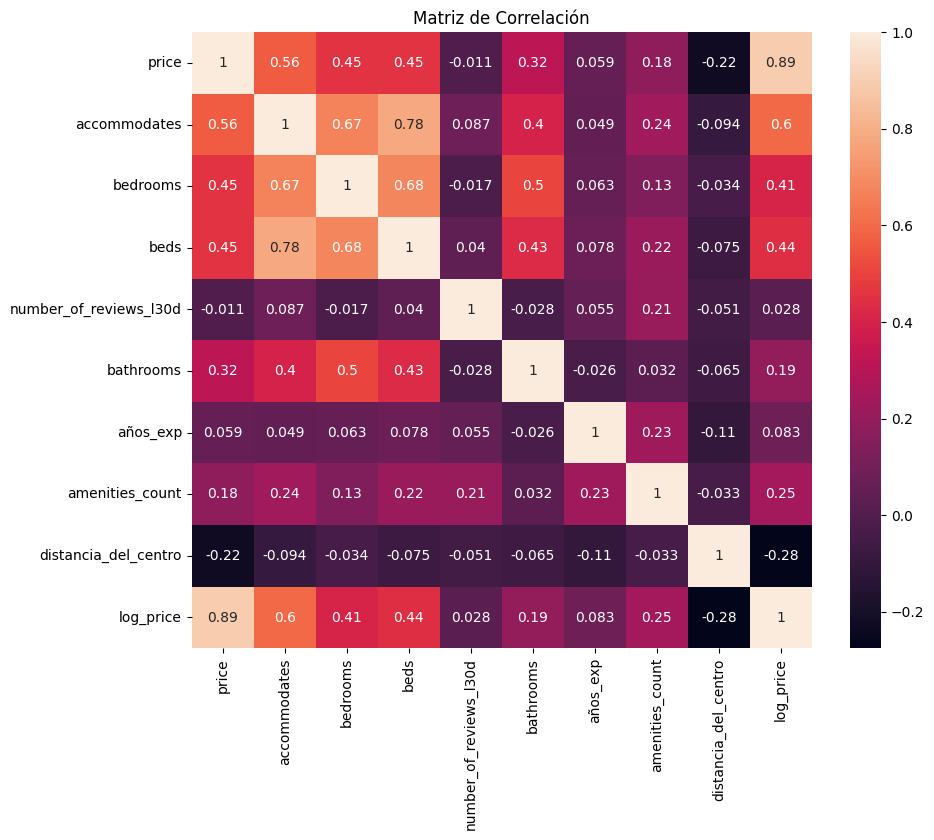

In [429]:
corr = data_final.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True)
plt.title('Matriz de Correlación')
plt.show()

In [430]:
corr = data_final.select_dtypes(include=[np.number]).corr()
corr["price"].sort_values(ascending=False)

,price
price,1.000000
log_price,0.891486
accommodates,0.564280
bedrooms,0.454670
beds,0.454197
bathrooms,0.319356
amenities_count,0.184748
años_exp,0.058968
number_of_reviews_l30d,-0.010755
distancia_del_centro,-0.224278


## 3. Estrategia de Modelado: Econometría vs. Machine Learning

Para predecir la variable objetivo `log_price`, implementaremos una estrategia incremental de complejidad:

1.  **Regresión Lineal (OLS):** Servirá como *Benchmark*. Nos permite cuantificar el impacto exacto (coeficientes beta) de cada variable y probar la significancia estadística.
2.  **Random Forest Regressor:** Un modelo de ensamblaje basado en *Bagging*. Su capacidad para crear múltiples árboles de decisión le permite capturar relaciones no lineales (ej: la distancia importa mucho al principio, pero menos después de ciertos km).
3.  **XGBoost (Optimizado):** El estado del arte en datos tabulares. Utiliza *Gradient Boosting* para corregir iterativamente los errores de los árboles previos. Optimizaremos sus hiperparámetros mediante `RandomizedSearchCV` para buscar la máxima precisión posible ($R^2$).

### 3.1 Preparación del modelo

In [431]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [432]:
data_model = pd.get_dummies(data_final,columns = ['room_type'], drop_first=True)

In [433]:
variables_modelo = ['accommodates', 'bedrooms', 'number_of_reviews_l30d',
       'bathrooms', 'años_exp', 'amenities_count', 'distancia_del_centro',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room']

In [434]:
X = data_model[variables_modelo]
y = data_model["log_price"]

In [435]:
#Train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [436]:
print(f"Entrenando con {X_train.shape[0]} inmuebles.")
print(f"Probando con {X_test.shape[0]} inmuebles.")

Entrenando con 15004 inmuebles.
Probando con 3752 inmuebles.


### Modelo de Regresión Lineal

In [437]:
modelo_lineal = LinearRegression()

In [438]:
modelo_lineal.fit(X_train,y_train)

LinearRegression()

In [439]:
y_pred_mco = modelo_lineal.predict(X_test)

In [440]:
print("\n--- Resultados Regresión Lineal ---")
print(f"MSE: {mean_squared_error(y_test,y_pred_mco)}")
print(f"R^2: {r2_score(y_test,y_pred_mco)}")


--- Resultados Regresión Lineal ---
MSE: 0.2115171736691369
R^2: 0.5275512784297184


In [441]:
import statsmodels.api as sm
#1. Convertimos todos los True/False a 1.0/0.0
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# 2. AÑADIR LA CONSTANTE (Intercepto)
X_train_stats = sm.add_constant(X_train)

# 3. AJUSTAR EL MODELO AHORA SÍ
modelo_ols = sm.OLS(y_train, X_train_stats).fit()

# 4. IMPRIMIR LA TABLA DE RESULTADOS
print(modelo_ols.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     1719.
Date:                Thu, 18 Dec 2025   Prob (F-statistic):               0.00
Time:                        04:28:36   Log-Likelihood:                -9527.9
No. Observations:               15004   AIC:                         1.908e+04
Df Residuals:                   14993   BIC:                         1.916e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      4

### 💡 Interpretación Económica del Modelo Lineal

Los resultados de la regresión validan varias hipótesis fundamentales:
* **La Ubicación es Dinero:** El coeficiente negativo de `distancia_del_centro` confirma que por cada kilómetro que nos alejamos de Sol, el precio cae significativamente (validación de la teoría de Alonso-Muth-Mills).
* **El Costo de la Privacidad:** Las variables `Private room` y `Shared room` tienen coeficientes negativos muy fuertes respecto a la base ("Entire home"). Esto indica que la privacidad es el atributo más costoso del mercado.
* **Irrelevancia de la "Experiencia":** Curiosamente, la variable `años_exp` no resultó estadísticamente significativa, sugiriendo que el mercado es eficiente y no paga una prima solo por la antigüedad del anfitrión.

### Modelos de Machine Learning

#### Modelo de Random Forest

In [442]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [443]:
param_dist_forest = {
    'n_estimators': [100, 200, 300],        # Número de árboles
    'max_depth': [10, 20, 30, None],        # Profundidad
    'min_samples_split': [2, 5, 10],        # Mínimo de datos para dividir una rama
    'min_samples_leaf': [1, 2, 4]           # Mínimo de datos en una hoja final
}

In [444]:
modelo_forest = RandomForestRegressor(random_state = 42)

In [445]:
random_search = RandomizedSearchCV(
    estimator=modelo_forest,
    param_distributions=param_dist_forest,
    n_iter=10,           # ¡La clave! Solo probará 10 combinaciones al azar (rápido)
    cv=3,                # Validación cruzada de 3 pliegues (divide train en 3 partes)
    verbose=1,           # Para que nos vaya contando qué hace
    random_state=42,     # Para que a ti y a mí nos salga lo mismo
    n_jobs=-1            # Usa todos los núcleos de tu procesador
)

In [446]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=1)

In [447]:
random_search.best_params_

{'n_estimators': 300,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': None}

In [448]:
best_model_forest = random_search.best_estimator_

In [449]:
y_pred_forest = best_model_forest.predict(X_test)

In [450]:
print(f"MSE: {mean_squared_error(y_test,y_pred_forest)}")
print(f"R^2:{r2_score(y_test,y_pred_forest)}")

MSE: 0.14780331749507042
R^2:0.6698637411654225


In [451]:
importancias = best_model_forest.feature_importances_
nombres = X_train.columns
df_importances = pd.DataFrame({'Variable': nombres, 'Importancia': importancias}).sort_values(by='Importancia', ascending=False)

/tmp/ipython-input-1773681106.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importancia', y='Variable', data=df_importances,palette="viridis")


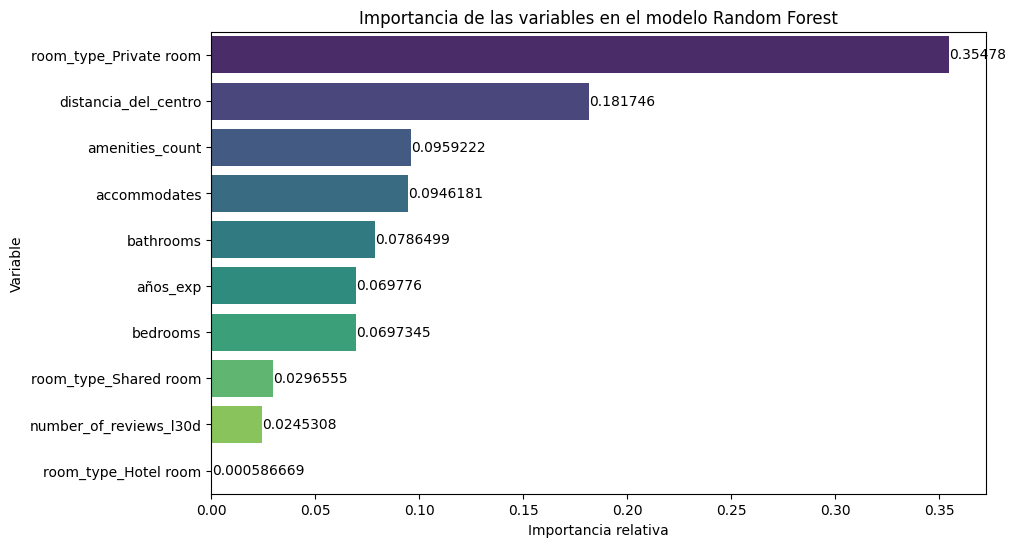

In [452]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importancia', y='Variable', data=df_importances,palette="viridis")
for container in ax.containers:
    ax.bar_label(container)
plt.title("Importancia de las variables en el modelo Random Forest")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.show()

#### Modelo de XGBoost

In [453]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [454]:
param_dist_xgb = {
    'n_estimators': [200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],               # Profundidad del árbol
    'subsample': [0.7, 0.8, 0.9, 1.0],    # Tope máximo 1.0 (100% de datos)
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0] # Tope máximo 1.0 (100% de columnas)
}

In [455]:
modelo_xgb = XGBRegressor(random_state=42)

In [456]:
random_search = RandomizedSearchCV(
    estimator=modelo_xgb,
    param_distributions=param_dist_xgb,
    n_iter=10,
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs = -1
)

In [457]:
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9,
                                                             1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [5, 7, 9],
                                        'n_estimators': [200, 300, 400, 500],
                                        'subsample': [0.7, 0.8, 0.9, 1.0]},
                   random_state=42, verbose=1)

In [458]:
random_search.best_params_

{'subsample': 0.9,
 'n_estimators': 200,
 'max_depth': 9,
 'learning_rate': 0.05,
 'colsample_bytree': 0.7}

In [459]:
best_model_xgb = random_search.best_estimator_

In [460]:
y_pred_xgb = best_model_xgb.predict(X_test)

In [461]:
print(f"MSE: {mean_squared_error(y_test,y_pred_xgb)}")
print(f"R^2:{r2_score(y_test,y_pred_xgb)}")

MSE: 0.14541362577367734
R^2:0.6752014013616829


<Figure size 1000x600 with 0 Axes>

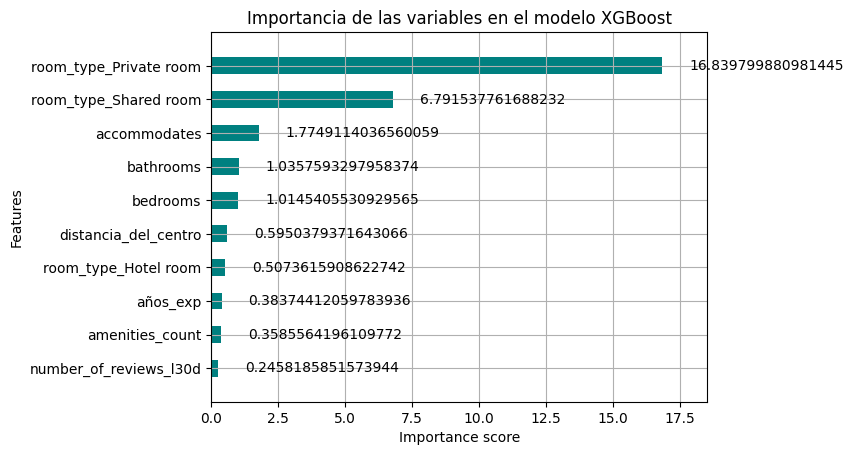

In [462]:
plt.figure(figsize=(10, 6))
plot_importance(best_model_xgb,importance_type="gain",max_num_features=15, height=0.5, color='teal')
plt.title("Importancia de las variables en el modelo XGBoost")
plt.show()

# 4. Conclusiones Finales y Recomendaciones

Tras comparar los tres enfoques de modelado, el algoritmo **XGBoost** resultó ser el ganador con un **$R^2$ de 0.675**, superando al modelo econométrico tradicional ($R^2$ 0.528) y al Random Forest ($R^2$ 0.670).

### Hallazgos Principales:

1.  **Superioridad del Machine Learning:** La mejora del **~15%** en la capacidad explicativa del XGBoost frente a la Regresión Lineal demuestra que el mercado inmobiliario de Madrid sigue reglas complejas y no lineales que un modelo simple no puede capturar.
2.  **Jerarquía de Valor (Feature Importance):**
    * 🥇 **Tipo de Alojamiento (Privacidad):** Es el factor determinante. La diferencia de precio entre alquilar un piso entero vs. compartir es abismal.
    * 🥈 **Capacidad (`Accommodates`):** El mercado valora "cabezas en camas". La capacidad de alojamiento es el segundo motor del precio.
    * 🥉 **Ubicación (`Distancia`):** La cercanía al centro es crucial, pero su importancia es secundaria frente a la privacidad y el tamaño.
3.  **Variables Sobreestimadas:** Factores como la cantidad de baños (controlando por capacidad) o la experiencia del anfitrión tienen un impacto marginal en el precio final.

### Implicación de Negocio:
Para un inversor o propietario en Madrid, la estrategia óptima para maximizar la tarifa diaria (**ADR**) consiste en priorizar la oferta de **alojamientos completos** (evitando la división por habitaciones) y maximizar la **capacidad de plazas** (sofás cama, literas), siendo la ubicación un factor importante pero que puede ser compensado con mayor capacidad.